In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

/opt/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
class GAN:
    def __init__(self,
                 sess,
                 latent_size=100,
                 input_size=28*28,
                 G_hidden_dim = [128,256],
                 D_hidden_dim=[256],
                 activation_function=tf.nn.relu,
                 learning_rate=0.0002,
                 optimizer=tf.train.AdamOptimizer):
        
        self.latent_size = latent_size
        self.input_size = input_size
        self.activation_function = activation_function
        
        self.G_input = tf.placeholder(tf.float32, [None, self.latent_size], name='g_input')
        self.D_input = tf.placeholder(tf.float32, [None, self.input_size], name='d_input')
        
        ## GENERATOR_VARIABLE
        self.G_W1 = tf.Variable(tf.random_normal([100, 256], stddev=0.01))
        self.G_W2 = tf.Variable(tf.random_normal([256, 28 * 28], stddev=0.01))
        self.G_b1 = tf.Variable(tf.zeros([256]))
        self.G_b2 = tf.Variable(tf.zeros([28 * 28]))
        self.G_var_list = [self.G_W1, self.G_W2, self.G_b1, self.G_b2]
        
        ## DISCRIMIMNATOR VARIABLE
        self.D_W1 = tf.Variable(tf.random_normal([28*28, 256], stddev=0.01))
        self.D_W2 = tf.Variable(tf.random_normal([256, 64], stddev=0.01))
        self.D_W3 = tf.Variable(tf.random_normal([64, 1], stddev=0.01))
        self.D_b1 = tf.Variable(tf.zeros([256]))
        self.D_b2 = tf.Variable(tf.zeros([64]))
        self.D_b3 = tf.Variable(tf.zeros([1]))
        self.D_var_list = [self.D_W1, self.D_W2, self.D_W3, self.D_b1, self.D_b2, self.D_b3]
        
        ###DEFINE LOSS FUNCTION
        self.G = self.generator(self.G_input)
        self.loss_D = -(tf.reduce_mean(tf.log(self.discriminator(self.D_input)) + tf.log(1 - self.discriminator(self.G))))
        self.loss_G = -tf.reduce_mean(tf.log(self.discriminator(self.G)))
        self.train_D = optimizer(learning_rate=learning_rate).minimize(self.loss_D, var_list=self.D_var_list)
        self.train_G = optimizer(learning_rate=learning_rate).minimize(self.loss_G, var_list=self.G_var_list)
        
        self.sess = sess
        self.sess.run(tf.global_variables_initializer())
    
    def train(self, g_input, d_input):
        feed_dict_D = {
            self.G_input: g_input,
            self.D_input: d_input
        }
        d_loss, _ = self.sess.run([self.loss_D, self.train_D], feed_dict=feed_dict_D)
        
        feed_dict_G ={
            self.G_input: g_input
        }
        g_loss, _ = self.sess.run([self.loss_G, self.train_G], feed_dict=feed_dict_G)
        
        return d_loss, g_loss
    
    def generating_images(self, g_input):
        feed_dict = {
            self.G_input: g_input
        }
        return self.sess.run(self.G, feed_dict=feed_dict)
            
    
    def generator(self, X):
        hidden_layer = self.activation_function(tf.matmul(X, self.G_W1) + self.G_b1)
        output_layer = tf.nn.sigmoid(tf.matmul(hidden_layer, self.G_W2) + self.G_b2)
        return output_layer
    
    def discriminator(self, X):
        hidden_layer_1 = self.activation_function(tf.matmul(X, self.D_W1) + self.D_b1)
        hidden_layer_2 = self.activation_function(tf.matmul(hidden_layer_1, self.D_W2) + self.D_b2)
        output_layer = tf.nn.sigmoid(tf.matmul(hidden_layer_2, self.D_W3) + self.D_b3)
        return output_layer
        

In [8]:
sess = tf.Session()
model = GAN(sess)

In [9]:
TRAINING_EPOCHS = 100
BATCH_SIZE = 100

0 0.486925081597 2.86649780902


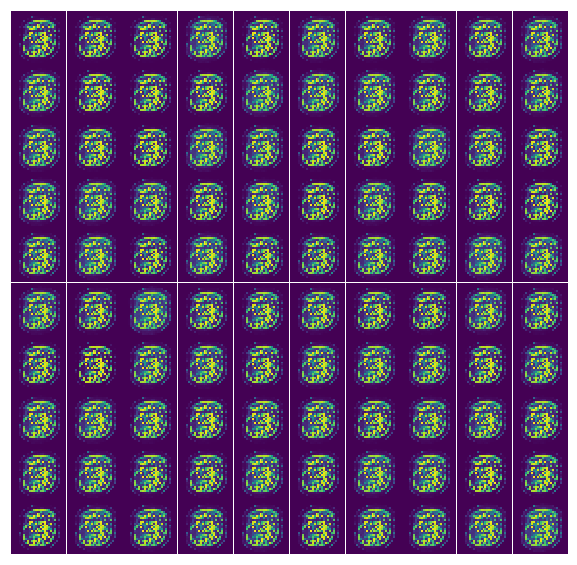

10 0.149347897511 4.5775446662


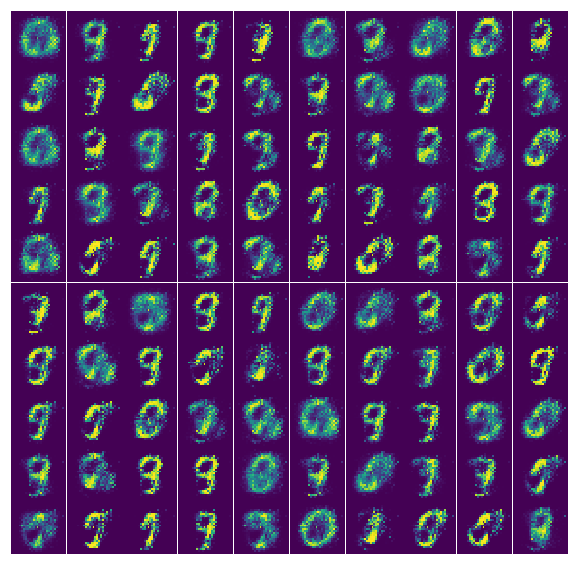

20 0.281578768234 3.73429742683


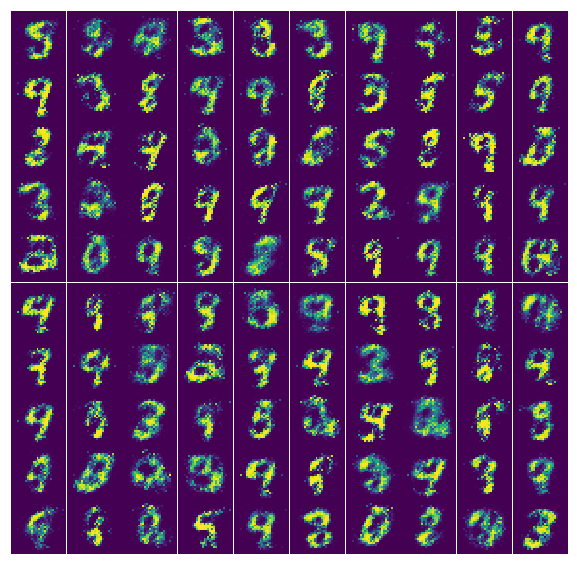

30 0.321668261804 3.46669537501


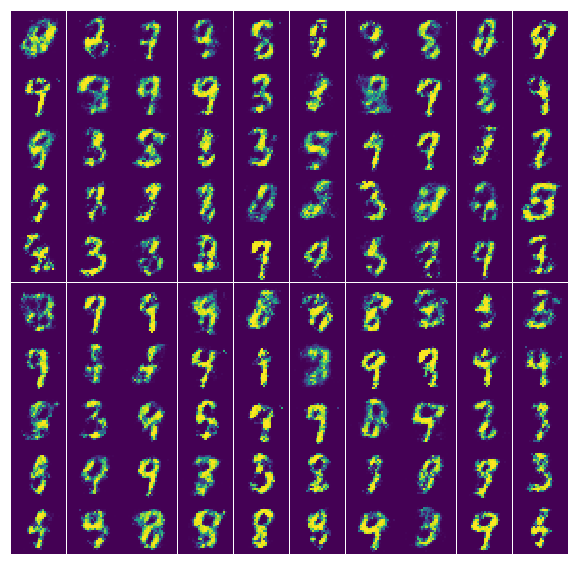

40 0.369785589413 3.25977986076


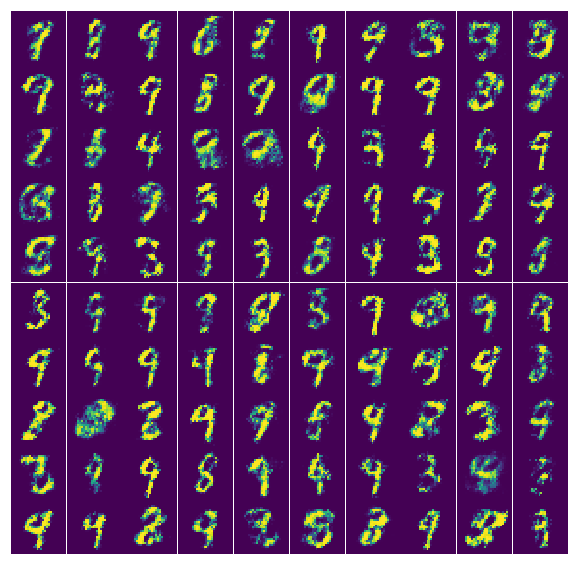

50 0.415511907556 3.06381011659


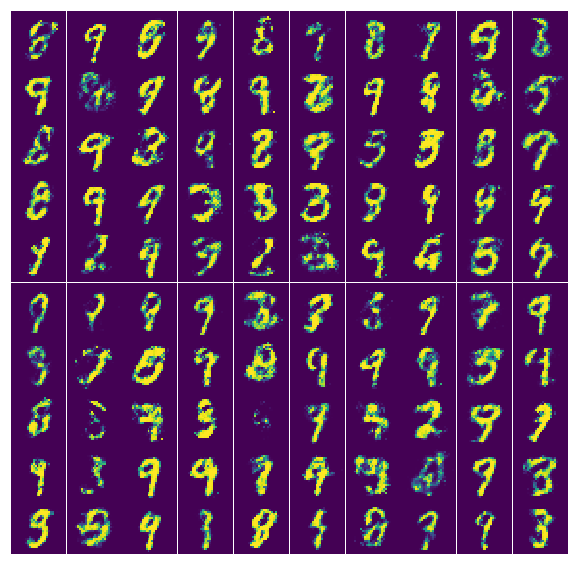

60 0.422383430681 3.01050570185


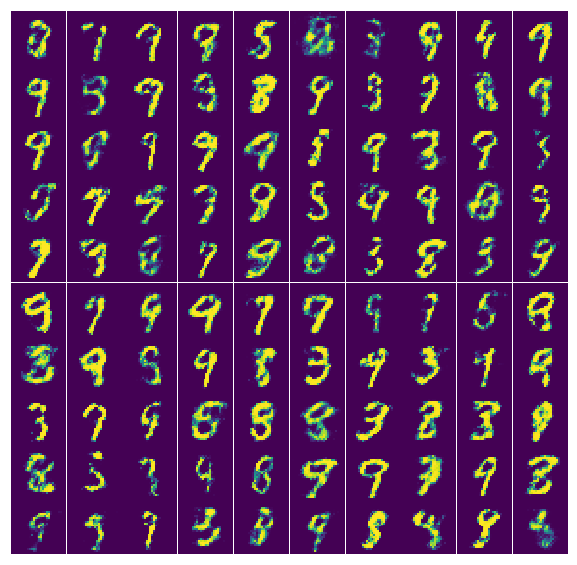

70 0.428907549165 2.952034613


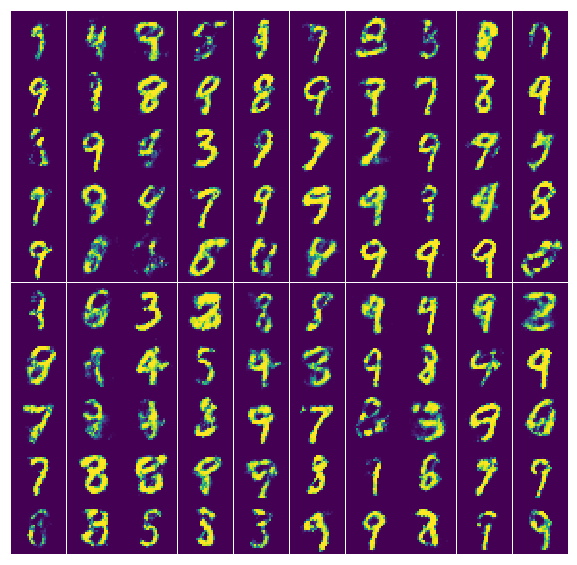

80 0.412784113586 3.01402779492


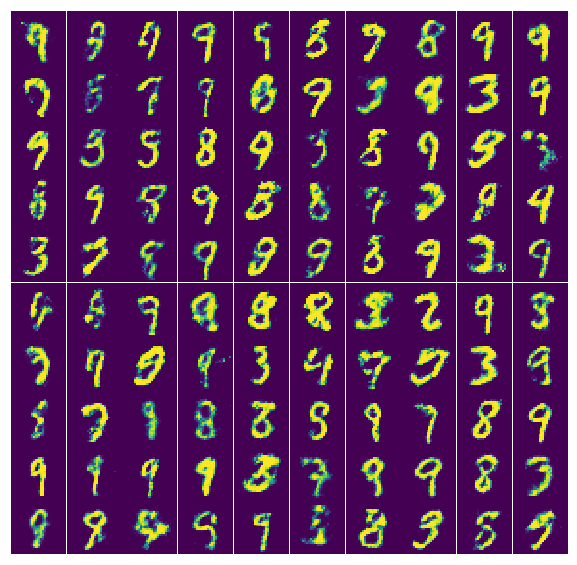

90 0.386721440445 3.13998204751


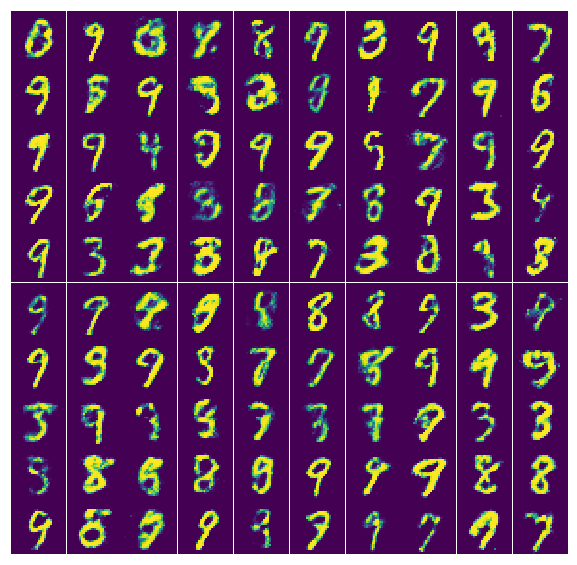

In [10]:
for epoch in range(TRAINING_EPOCHS):
    total_batch = int(mnist.train.num_examples / BATCH_SIZE)
    average_d_loss = 0
    average_g_loss = 0
    
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(BATCH_SIZE)
        latent = np.random.normal(size=(BATCH_SIZE, 100))
        d_loss, g_loss = model.train(latent, batch_xs)
        average_d_loss += d_loss/total_batch
        average_g_loss += g_loss/total_batch
        
    if epoch % 10 == 0:
        print(epoch, average_d_loss, average_g_loss)
        test_latent = np.random.normal(size=(100, 100))
        reshaped_images = np.reshape(model.generating_images(test_latent), (-1, 28, 28))
        f, axarr = plt.subplots(10, 10, figsize=(10,10))
        for i in range(10):
            for j in range(10):
                axarr[i, j].imshow(reshaped_images[i*10 + j])
                axarr[i, j].axis('off')
                axarr[i, j].set_xticklabels([])
                axarr[i, j].set_yticklabels([])
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig('Results/GAN/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.show()
        plt.close(f)